# Imports

In [1]:
import tensorflow as tf
import os
from os.path import exists
from tensorflow.python.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
import random
from mpl_toolkits.basemap import Basemap
import loadingbar
import matplotlib.animation as animation

In [2]:
# set working dir to root, to access saved models and data
os.chdir('C:/Users/zacha/Documents/GitHub/plymouth-university-proj518')
print(os.getcwd())

C:\Users\zacha\Documents\GitHub\plymouth-university-proj518


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
def mirror(model, df, yscaler):
    pred = model.predict(df)    # batch predict using model

    pred = yscaler.inverse_transform(pred)  # transform back to original scale

    # join prediction with original dataframe
    df['Chi'] = pred

    return df

# Wind-Time

In [5]:
# load wind model
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'wind_time_regression_model_25082022164000.h5'
model_path = os.path.join(save_dir, model_name)

if exists(model_path):  # load model if exists
    print(f"LOADING MODEL: {model_path}")
    wind_time_model = load_model(model_path)
else:   # else generate new model
    raise Exception("NO MODEL FOUND")

wind_time_model.summary()

LOADING MODEL: C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\saved_models\wind_time_regression_model_25082022164000.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_16 (Dense)             (None, 1024)            

In [6]:
# load wind model input scaler
save_dir = os.path.join(os.getcwd(), 'saved_models')
scaler_name = 'wind_time_scaler_25082022164000'
scaler_path = os.path.join(save_dir, scaler_name)

yscaler = joblib.load(scaler_path)

In [7]:
file = 'data/NCEP daily velocity potential reanalysis.csv'
df = pd.read_csv(file, sep=',')
print(df['Day'].min(), df['Day'].max())

# randomly select day to sample
day = random.randint(df['Day'].min(), df['Day'].max())

# filter dataframe to only include day of interest
df_day = df[df['Day'] == day]

# drop 'Chi' from dataframe
test_df = df_day.drop(columns=['Chi'])


0 228


In [8]:
# predict values at same datapoints as csv
wind_time_predicted = mirror(wind_time_model, test_df, yscaler)

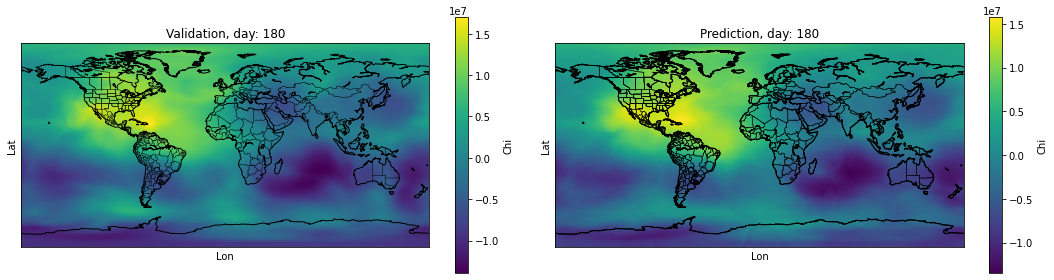

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

# plot known data
ax = axes[0]
mp = Basemap(ax=ax)
title = f'Validation, day: {day}'
ax.title.set_text(title)
map = ax.scatter(df_day['Lon'], df_day['Lat'], c=df_day['Chi'], cmap='viridis')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Chi')

# plot predicted values at day of interest
ax = axes[1]
mp = Basemap(ax=ax)
title = f'Prediction, day: {day}'
ax.title.set_text(title)
map = ax.scatter(wind_time_predicted['Lon'], wind_time_predicted['Lat'], c=wind_time_predicted['Chi'], cmap='viridis')
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Chi')

plt.tight_layout()
plt.show()

██████████████████████████████████████████████████0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m0m


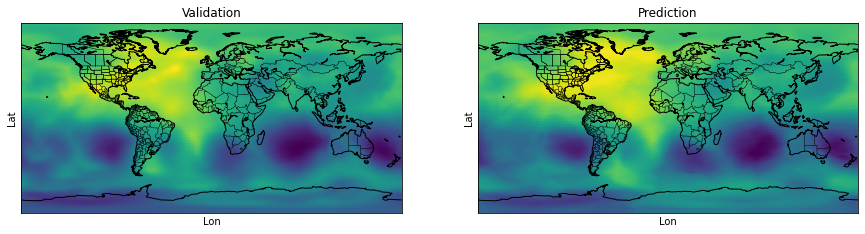

In [12]:
L = loadingbar.LoadingBar(df['Day'].max())

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

df_day = df[df['Day'] == df['Day'].min()]
ax1.scatter(df_day['Lon'], df_day['Lat'], c=df_day['Chi'], cmap='viridis')

test_df = df_day.drop(columns=['Chi'])
wind_time_predicted = mirror(wind_time_model, test_df, yscaler)
ax2.scatter(wind_time_predicted['Lon'], wind_time_predicted['Lat'], c=wind_time_predicted['Chi'], cmap='viridis')

ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')
ax1.set_title("Validation")

ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')
ax2.set_title("Prediction")

mp1 = Basemap(ax=ax1)
mp2 = Basemap(ax=ax2)

def update(i):
    L.update(1)

    if i > 228:
        i = 0
    
    ax1.clear()
    ax1.collections.clear()

    ax2.clear()
    ax2.collections.clear()

    df_day = df[df['Day'] == i]
    ax1.scatter(df_day['Lon'], df_day['Lat'], c=df_day['Chi'], cmap='viridis')
    mp1.drawcoastlines()
    mp1.drawstates()
    mp1.drawcountries()

    test_df = df_day.drop(columns=['Chi'])
    wind_time_predicted = mirror(wind_time_model, test_df, yscaler)
    ax2.scatter(wind_time_predicted['Lon'], wind_time_predicted['Lat'], c=wind_time_predicted['Chi'], cmap='viridis')
    mp2.drawcoastlines()
    mp2.drawstates()
    mp2.drawcountries()

    ax1.set_xlabel('Lon')
    ax1.set_ylabel('Lat')
    ax1.set_title("Validation")

    ax2.set_xlabel('Lon')
    ax2.set_ylabel('Lat')
    ax2.set_title("Prediction")

ani = animation.FuncAnimation(fig, update, frames=df['Day'].max(), interval=100, blit=False)
ani.save("Validation vs Prediction.gif", writer="imagemagick")

L.done()